['HB Køge vs AaB' 'AaB vs Horsens' 'Esbjerg vs AaB' 'AaB vs Hvidovre'
 'Aarhus Fremad vs Lyngby' 'Aarhus Fremad vs Hillerød'
 'Hvidovre vs Aarhus Fremad' 'Aarhus Fremad vs Kolding' 'Hobro vs B 93'
 'B 93 vs Esbjerg' 'HB Køge vs B 93' 'B 93 vs Kolding'
 'Esbjerg vs Kolding' 'Hobro vs Esbjerg' 'Kolding vs HB Køge'
 'Hillerød vs HB Køge' 'Hillerød vs Hobro' 'Lyngby vs Hillerød'
 'Hobro vs Horsens' 'Horsens vs Middelfart' 'Lyngby vs Horsens'
 'Lyngby vs Hvidovre' 'Hvidovre vs Middelfart' 'Hobro vs Middelfart'
 'Middelfart vs Esbjerg']

=== Overall (High base OR Pocket OR Width) ===
         Team  Opportunities / match  Deep runs / match  Conversion rate (%)
      Esbjerg                   57.8               13.8                 23.6
     Hvidovre                   58.0               11.8                 20.1
      Kolding                   82.5               13.5                 16.9
         B_93                   82.5               13.5                 16.3
   Middelfart                 

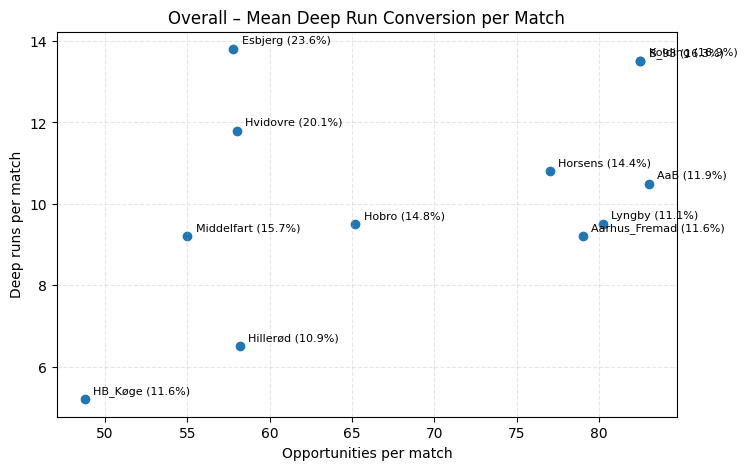


=== High base ===
         Team  Opportunities / match  Deep runs / match  Conversion rate (%)
      Esbjerg                   27.2                4.5                 16.2
      Horsens                   44.8                5.0                 11.6
     Hvidovre                   26.0                3.2                 11.6
          AaB                   49.0                5.0                 11.0
Aarhus_Fremad                   44.0                4.8                 10.4
      HB_Køge                   28.0                2.5                  9.9
      Kolding                   42.2                4.0                  9.9
        Hobro                   31.0                3.0                  9.3
         B_93                   48.0                4.2                  8.4
   Middelfart                   26.2                1.8                  6.4
       Lyngby                   46.0                3.0                  6.2
     Hillerød                   35.2                1.8  

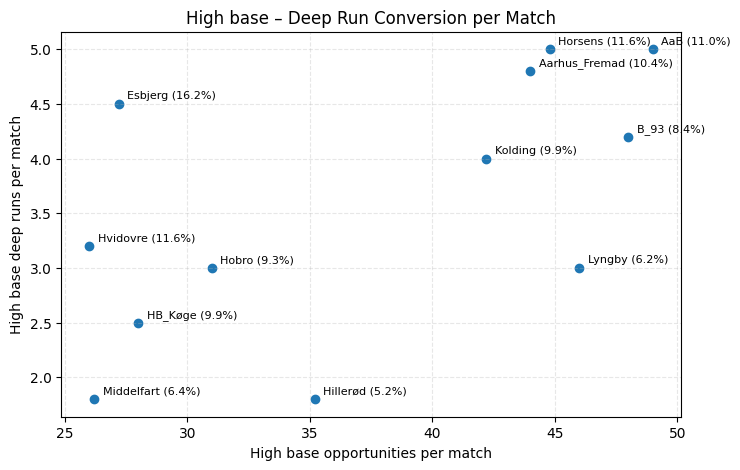


=== Pocket ===
         Team  Opportunities / match  Deep runs / match  Conversion rate (%)
         B_93                   19.0                7.5                 38.2
      Esbjerg                   15.5                5.5                 35.0
      Kolding                   18.5                6.0                 34.0
     Hvidovre                   17.8                5.5                 30.6
       Lyngby                   16.0                4.2                 27.5
        Hobro                   17.8                4.2                 23.4
          AaB                   15.2                4.0                 19.2
Aarhus_Fremad                   16.5                3.2                 18.7
      Horsens                   14.8                3.2                 18.3
      HB_Køge                   10.0                1.8                 18.2
     Hillerød                   13.2                2.5                 17.4
   Middelfart                   15.8                3.2     

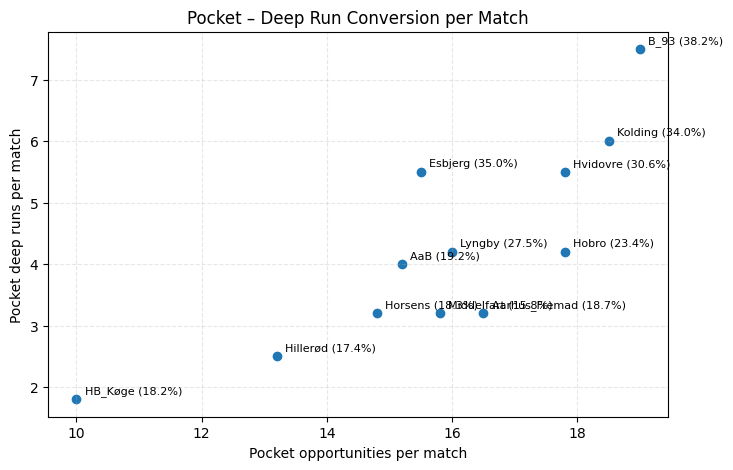


=== Width ===
         Team  Opportunities / match  Deep runs / match  Conversion rate (%)
   Middelfart                   18.8                5.5                 28.5
      Esbjerg                   23.8                5.8                 23.9
        Hobro                   23.2                5.0                 21.5
     Hvidovre                   20.5                4.2                 21.2
      Horsens                   24.8                4.5                 20.8
      Kolding                   31.8                6.0                 20.2
     Hillerød                   14.5                3.2                 19.1
         B_93                   24.2                4.5                 18.9
Aarhus_Fremad                   29.5                4.5                 15.0
       Lyngby                   26.2                3.8                 13.5
          AaB                   28.2                4.0                 13.3
      HB_Køge                   17.0                1.5      

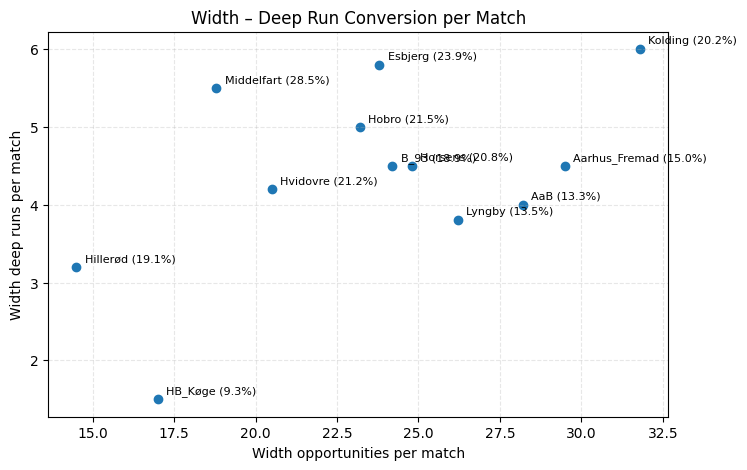

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# -------- CONFIG --------
BASE_PATH = r"C:\Users\Seamus-admin\Documents\GitHub\AC-Horsens-First-Team\DNK_1_Division_2025_2026"
USE_STREAMLIT = False  # set True if running inside Streamlit

if USE_STREAMLIT:
    import streamlit as st

# -------- LOADING --------
def load_all_teams(base_path: str, n_last_matches: int = 4) -> pd.DataFrame:
    teams = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    dfs = []
    for team in teams:
        file_path = os.path.join(base_path, team, f"{team}_on_ball_sequences.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df["team"] = team
            dfs.append(df)

    if not dfs:
        raise FileNotFoundError("No team CSVs found under the base path.")

    df_all = pd.concat(dfs, ignore_index=True)

    # ensure datetime
    df_all["local_date"] = pd.to_datetime(df_all["local_date"], errors="coerce")

    # compute the last N unique dates per team
    lastN_per_team = (
        df_all[["team", "local_date"]]
        .drop_duplicates()
        .sort_values(["team", "local_date"], ascending=[True, False])
    )
    lastN_per_team["date_rank"] = lastN_per_team.groupby("team")["local_date"] \
                                               .rank(method="dense", ascending=False)

    keep_dates = lastN_per_team[lastN_per_team["date_rank"] <= n_last_matches][["team", "local_date"]]

    # filter original to those dates per team
    df_filtered = df_all.merge(keep_dates, on=["team", "local_date"], how="inner")
    print(df_filtered['description'].unique())
    return df_filtered

# usage
df_all = load_all_teams(BASE_PATH, n_last_matches=4)
# -------- CORE CALC HELPERS --------
def _mask_for_concept(df: pd.DataFrame, concept: str | None):
    """Return mask for: (concept True) AND (deep_run_opportunity True).
       If concept is None, use OR across High base, Pocket, Width.
    """
    if concept is None:
        concept_mask = (df["High base"] == True) | (df["Pocket"] == True) | (df["Width"] == True)
    else:
        concept_mask = (df[concept] == True)
    opportunity_mask = (df["deep_run_opportunity"] == True)
    return concept_mask & opportunity_mask

def per_match_summary(df: pd.DataFrame, concept: str | None = None) -> pd.DataFrame:
    """
    Build per-match summary for a given concept (or overall if concept=None):
      - opportunities: unique (sequence_id, match_id, team)
      - deep_runs: all rows with deep_run==True
      - conversion per match
    Returns one row per (team, match_id).
    """
    mask = _mask_for_concept(df, concept)

    # Unique opportunities (dedupe by sequence & match & team)
    opps_per_match = (
        df[mask]
        .drop_duplicates(subset=["sequence_id", "match_id", "team"])
        .groupby(["team", "match_id"])
        .size()
        .reset_index(name="opportunities")
    )

    # All deep runs (no dedupe)
    runs_per_match = (
        df[mask & (df["deep_run"] == True)]
        .groupby(["team", "match_id"])
        .size()
        .reset_index(name="deep_runs")
    )

    # Merge & fill
    summary = (
        opps_per_match.merge(runs_per_match, on=["team", "match_id"], how="left")
        .fillna(0)
    )

    # Conversion per match
    summary["conversion_rate_%"] = (
        (summary["deep_runs"] / summary["opportunities"]) * 100
    ).round(1)

    return summary

def mean_per_match_per_team(summary_per_match: pd.DataFrame) -> pd.DataFrame:
    """Average per match for each team (opportunities, deep_runs, conversion%)."""
    mean_df = (
        summary_per_match.groupby("team", as_index=False)[["opportunities", "deep_runs", "conversion_rate_%"]]
        .mean()
        .round(1)
    )
    return mean_df

# -------- PRESENTATION TABLES --------
def format_presentation_table(df_mean: pd.DataFrame, title: str | None = None) -> pd.DataFrame:
    out = df_mean.copy()
    out.columns = ["Team", "Opportunities / match", "Deep runs / match", "Conversion rate (%)"]
    out = out.sort_values("Conversion rate (%)", ascending=False)
    if USE_STREAMLIT:
        if title:
            st.subheader(title)
        st.table(out)
    else:
        if title:
            print(f"\n=== {title} ===")
        print(out.to_string(index=False))
    return out

# -------- PLOTS --------
def scatter_mean_table(mean_df: pd.DataFrame, title: str, xlabel: str, ylabel: str):
    # ensure numeric
    mean_df["opportunities"] = pd.to_numeric(mean_df["opportunities"], errors="coerce").fillna(0)
    mean_df["deep_runs"]     = pd.to_numeric(mean_df["deep_runs"], errors="coerce").fillna(0)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(mean_df["opportunities"], mean_df["deep_runs"])
    for _, row in mean_df.iterrows():
        label = f"{row['team']} ({row['conversion_rate_%']}%)"
        ax.annotate(label, (row["opportunities"], row["deep_runs"]),
                    textcoords="offset points", xytext=(6, 4), fontsize=8)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.3)

    if USE_STREAMLIT:
        st.pyplot(fig, use_container_width=True)
    else:
        plt.show()

# -------- RUN: OVERALL (High base OR Pocket OR Width) --------
overall_per_match = per_match_summary(df_all, concept=None)
overall_mean = mean_per_match_per_team(overall_per_match)

overall_table = format_presentation_table(
    overall_mean.rename(columns={"team": "Team", "opportunities": "Opportunities / match",
                                 "deep_runs": "Deep runs / match", "conversion_rate_%": "Conversion rate (%)"}),
    title="Overall (High base OR Pocket OR Width)"
)

scatter_mean_table(
    overall_mean.rename(columns={"team": "team"}),
    title="Overall – Mean Deep Run Conversion per Match",
    xlabel="Opportunities per match",
    ylabel="Deep runs per match"
)

# -------- RUN: PER CONCEPT --------
for concept in ["High base", "Pocket", "Width"]:
    per_match = per_match_summary(df_all, concept=concept)
    mean_df = mean_per_match_per_team(per_match)

    format_presentation_table(
        mean_df.rename(columns={"team": "Team", "opportunities": "Opportunities / match",
                                "deep_runs": "Deep runs / match", "conversion_rate_%": "Conversion rate (%)"}),
        title=f"{concept}"
    )

    scatter_mean_table(
        mean_df.rename(columns={"team": "team"}),
        title=f"{concept} – Deep Run Conversion per Match",
        xlabel=f"{concept} opportunities per match",
        ylabel=f"{concept} deep runs per match"
    )

